# Machine Learning LAB 2: SUPPORT VECTOR MACHINES

Course 2023/24: *M. Caligiuri*, *P. Talli*, *F. Lincetto*, *F. Chiariotti*, *P. Zanuttigh*

The notebook contains some simple tasks to be performed with **SUPPORT VECTOR MACHINES (SVM)**.

Complete all the **required code sections** and **answer to all the questions**.

### IMPORTANT for the evaluation score:

1. **Read carefully all cells** and **follow the instructions**.
2. **Re-run all the code from the beginning** to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebooks.
3. Make sure to fill the code in the appropriate places **without modifying the template**, otherwise you risk breaking later cells.
4. Please **submit the jupyter notebook file (.ipynb)**, do not submit python scripts (.py) or plain text files. **Make sure that it runs fine with the restat&run all command**.
5. **Answer the questions in the appropriate cells**, not in the ones where the question is presented.

## Weather Classification with Support Vector Machines

In this notebook we are going to explore the use of Support Vector Machines (SVM) for weather classification. We will use a dataset collected using the Luxottica **iSee** glasses. These devices provide multiple **sensors mounted inside the glasses**, which can be accessed through a bluetooth connection.

![I-SEE Glasses](data/isee.png "I-SEE")

The dataset corresponds to 8 hours of atmospherical data recordings sampled every 3 seconds.

The dataset labels are the following:

| ID  | Label       |
| :-: | :-:         |
| 0   | Sunny       |
| 1   | Rain        |
| 2   | Cloudy      |
| 3   | Mostly Clear|

---

## Preliminary step

Place your **name** and **ID number** (matricola) in the cell below. <br>
Also recall to **save the file as Surname_Name_LAB02.ipynb**, failure to do so will incur in a **lower grade**.

**Student name**: Alberto Salvador

**ID Number**: 2112317


---

## Import all the necessary Python libraries

In [1]:
%matplotlib inline

import typing as tp
import numpy as np
import itertools
from matplotlib import pyplot as plt
import sklearn.metrics as skm
from sklearn.svm import SVC
from sklearn import linear_model

---

## Define the heplper functions

In this section you will find some helper functions (some already implemented, some to be implemented by you) that will be used in the following sections.
1. `load_dataset` -> to load the dataset from the file `data/lux.npz`,
2. `plot_input` -> to plot the input data,
3. `k_split` ->  to split the trainig dataset in k different folds,
4. `k_fold_cross_validation` -> to perform the k-fold cross validation.

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [2]:
# Helper function to load the dataset
def load_dataset(path: str) -> tp.Tuple[np.ndarray, np.ndarray]: #definizione che specifica il tipo di input e output che ci si attende
    with np.load(path) as data:
        x, y = data["x"], data["y"] #data["x"] and data["y"] refer to the arrays stored in the NPZ file under the keys "x" and "y," respectively
        
        # Normalize the data (typical in machine learning application, in order to have zero mean and one std)
        x -= x.mean(axis=0)
        x /= x.std(axis=0)
        
        
    return x, y # the function returns a tuple (x, y) containing the normalized x array and the y array.

In [3]:
# Function for plotting a image and printing the corresponding label
def plot_input(X_matrix: np.ndarray, labels: np.ndarray) -> None:
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    cmap = plt.cm.get_cmap('Accent', 4)
    im = ax.scatter(X_matrix[:,0], X_matrix[:,1], X_matrix[:,2], c=labels, cmap=cmap)
    im.set_clim(-0.5, 3.5)
    cbar=fig.colorbar(im, ticks=[0,1,2,3], orientation='vertical', cmap=cmap)
    cbar.ax.set_yticklabels(['Sunny', 'Rainy','Cloudy', 'Mostly clear']) 

In [34]:
# Function to split the dataset in k different folds
def k_split(x: np.ndarray, y:np.ndarray, k: int, shuffle: bool = True) -> tp.Tuple[list[np.ndarray], list[np.ndarray]]:
    # Shuffle the dataset
    if shuffle:
        # Create a list of indices
        idx = np.arange(x.shape[0])
        # Randomly shuffle the indices
        np.random.shuffle(idx)
        # Shuffle the dataset
        x = x[idx]
        y = y[idx]

    # Split the dataset in k folds
    a = []
    b = []
    dim_fold = int(x.shape[0]/4)
   # print(x.shape[0]/4, int(x.shape[0]/4))
    for i in range(4):
        a.append(x[i*dim_fold:(i+1)*dim_fold])
        b.append(y[i*dim_fold:(i+1)*dim_fold])
        
    return (a,b)



In [65]:
# Function to perform the k-fold cross validation
def k_fold_cross_validation(x_train: np.ndarray, y_train: np.ndarray, k: int, model: SVC, parameters: dict) -> tp.Tuple[tuple, tuple]:
    # Define the folds for the cross validation
    x_folds, y_folds = k_split(x_train, y_train, k) #sono due liste di array 
    # Build a list containing all of the possible combinatioon of parameters
    params = list(itertools.product(*parameters.values()))
    print("params", params)

    # Initialize the dictionary of results
    results = {k: 0 for k in params}
    print("results",results)

    # For each param combination, perform the SVM training and testing
    for param in params:
        param = dict(zip(parameters.keys(), param))

        fold_accuracies = []
        
        model.set_params(**param)
        #SPIEGAZIONE:
        #For example, if param is {'C': 1.0, 'kernel': 'linear'}, then SVC(**param) is 
        #equivalent to SVC(C=1.0, kernel='linear')
        
        a = list(range(k))        
        
        for i in a:
            
            b_x = x_folds.copy()
            b_x.pop(i)
            
            b_y = y_folds.copy()
            b_y.pop(i)
                     
            x_training = np.concatenate(b_x)
            y_training = np.concatenate(b_y)
            
            x_test = x_folds[i]
            y_test = y_folds[i]

            model.fit(x_training, y_training)
        
            y_pred = model.predict(x_test)
        
            fold_accuracies.append(skm.accuracy_score(y_test, y_pred))


        # Compute the mean accuracy
        results[tuple(param.values())] = round(np.mean(fold_accuracies), 4)
    
    # Find the best parameters
    best_parameters = dict(zip(parameters.keys(), params[np.argmax(list(results.values()))]))
    best_accuracy = np.max(list(results.values()))
    best = (best_parameters, best_accuracy)

    # Add the param name to the results
    results = [({k: v for k, v in zip(parameters.keys(), p)}, a) for p, a in results.items()]

    return best, results

[1 2 3 4 5 6 7 8 9]


## A) Hyper-parameter search

### TO DO (A.0)

**Set** the random **seed** using your **ID**. If you need to change it for testing add a constant explicitly, eg.: 1234567 + 1

In [6]:
# fix your ID ("numero di matricola") and the seed for random generator
# as usual you can try different seeds by adding a constant to the number:
# ID = 1234567 + X
ID = 2112317 # YOUR ID (replace None with your ID)
np.random.seed(ID)

Before proceding to the training steps, we **load the dataset and split it** in training and test set (while the **training** set is **typically larger**, here we set the number of training samples to 1000 and 4000 for the test data).
The **split** is **performed after applying a random permutation** to the dataset, such permutation will **depend on the seed** you set above.

In [7]:
# Load the dataset using the helper function
X, y = load_dataset("data/lux.npz") #An NPZ file is a compressed archive of NumPy arrays in the NPZ format
print(X.shape, y.shape) #formato: (numero righe, elementi per ogni riga)
#X contiene i vari campionamenti di temperatura-umidità-..
#y contiene il meteo rilevato 


(15099, 3) (15099,)


In [8]:
#PER VISUALIZZARE IL DATASET
npz_file = np.load('data/lux.npz')
for key in npz_file.keys():
    print(f"{key}: {npz_file[key]}")

x: [[4.683500e+01 2.153600e+01 1.015265e+05]
 [4.672600e+01 2.214000e+01 1.015249e+05]
 [4.672900e+01 2.215800e+01 1.015242e+05]
 ...
 [4.575600e+01 2.955100e+01 1.013167e+05]
 [4.575200e+01 2.955700e+01 1.013157e+05]
 [4.576400e+01 2.956100e+01 1.013167e+05]]
y: [2. 2. 2. ... 0. 0. 0.]


In [9]:
# The task is quite easy, let's add noise to make it more challenging!
# You can try without noise (comment the next 2 lines, easy task), with the suggested amount of noise,
# or play with the suggested amount of noise 

noise = np.random.normal(0, 0.1, X.shape) #arrray di X.shape (=15099 righe di 3 elementi ciascuna) elementi di numeri fra 0 e 0.1 dirstribuiti secondo una gaussiana
X = X + noise
#PERCHE AGGIUNGIAMO IL RUMORE?

### TO DO (A.1)

**Divide** the **data into training and test set** (for this part use 1000 samples in the **first** set, 4000 in the **second** one). Make sure that each label is present at least 10 times in training. If it is not, then keep adding permutations to the initial data until this happens.


In [10]:
# Random permute the data and split into training and test taking the first 1000
# data samples as training and 4000 samples as test
permutation = np.random.permutation(X.shape[0]) # E' GIUSTO?
X=X[permutation]
y=y[permutation]

m_training = 1000
m_test = 4000

X_train = X[0:m_training] 
X_test = X[m_training:m_training+m_test] 
y_train = y[0:m_training] 
y_test = y[m_training:m_training+m_test]

print("X_train shape:", X_train.shape,"X_test shape:", X_test.shape,"||","y_train shape:",  y_train.shape,"y_test shape:", y_test.shape)

labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)


#E' GIUSTO CHE IL TRAIN (1000) SIA PIU' PICCOLO DEL TEST(4000)?
#INTENDONO CHE DOVREMMO VERIFICARE A OCCHIO CHE NON CI SIANO FREQUENZE MINORI DI 10 OPPURE DOBBIAMO IMPLEMENTARE UNA FUNZIONE APPOSTA?

X_train shape: (1000, 3) X_test shape: (4000, 3) || y_train shape: (1000,) y_test shape: (4000,)
Labels in training dataset:  [0. 1. 2. 3.]
Frequencies in training dataset:  [386 169 384  61]


In [48]:
x_folds, y_folds = k_split(X_train, y_train, 4) #sono due liste di array 
print(x_folds[0].shape,y_folds[0].shape)
b = x_folds.pop(1)
print(type(x_folds[0]))

(250, 3) (250,)
<class 'numpy.ndarray'>


/tmp/ipykernel_3159/31676135.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Accent', 4)


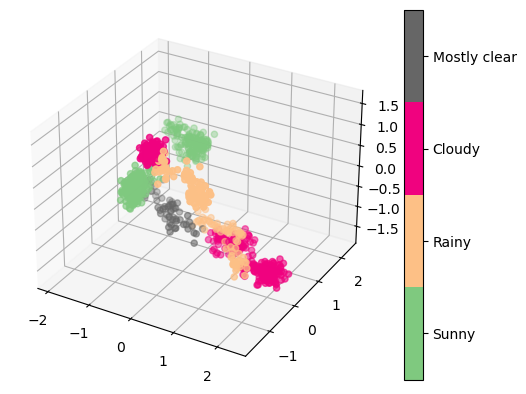

In [11]:
#Let's try the plotting function
plot_input(X_train,y_train)

### TO DO (A.2)

Use a SVM classfier with cross validation to pick a model. Use a 4-fold cross-validation. Let's start with a Linear kernel.

In [68]:
# Parameters for linear SVM
parameters = {'C': [ 0.01, 0.1, 1, 10]} #PERCHE' QUESTI VALORI?

# Define the model (without parameters)
svm = SVC(kernel='linear') #funzione che implementa svm con specifico kernel

# Perform the K-fold cross validation
best, results = k_fold_cross_validation(X_train, y_train, 4 , svm, parameters)

print ('RESULTS FOR LINEAR KERNEL')

print("Best parameter set found:")
print(best[0])

print("Score with best parameter:")
#print(results[best[0].key()) QUALCOSA DEL GENERE
print()
print("All scores on the grid:")
# ADD YOUR CODE HERE


SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (1142418405.py, line 16)

### TO DO (A.3)

Pick a model for the Polynomial kernel with degree=2.

In [ ]:
# Parameters for linear SVM
parameters = {'C': [0.01, 0.1, 1],'gamma':[0.01,0.1,1.]}

# Define an SVM with poly of degree 2 kernel (without parameters)
poly2_svm = None # ADD YOUR CODE HERE (replace None)

# Perform the K-fold cross validation
best, results = None # ADD YOUR CODE HERE (replace None)

print ('RESULTS FOR POLY DEGREE=2 KERNEL')

print("Best parameter set found:")
# ADD YOUR CODE HERE

print("Score with best parameter:")
# ADD YOUR CODE HERE
print()
print("All scores on the grid:")
# ADD YOUR CODE HERE

### TO DO (A.4)

Now let's try a higher degree for the polynomial kernel (e.g., 3rd degree).

In [ ]:
# Parameters for poly with higher degree kernel
parameters = {'C': [0.01, 0.1, 1],'gamma':[0.01,0.1, 1]}

# Define an SVM with poly of higher degree kernel (without parameters)
degree = 3
poly_svm = None # ADD YOUR CODE HERE (replace None)

# Perform the K-fold cross validation
best, results = None # ADD YOUR CODE HERE (replace None)

print (f"RESULTS FOR POLY DEGREE={degree} KERNEL")

print("Best parameter set found:")
# ADD YOUR CODE HERE

print("Score with best parameter:")
# ADD YOUR CODE HERE
print()
print("All scores on the grid:")
# ADD YOUR CODE HERE

### TO DO (A.5)

Pick a model for the Radial Basis Function kernel:

In [ ]:
# Parameters for rbf SVM
parameters = {'C': [0.1, 1, 10, 100],'gamma':[0.001, 0.01, 0.1,1]}

# Define an SVM with rbf kernel (without parameters)
rbf_svm = None # ADD YOUR CODE HERE (replace None)

# Perform the K-fold cross validation
best, results = None # ADD YOUR CODE HERE (replace None)

print ('RESULTS FOR rbf KERNEL')

print("Best parameter set found:")
# ADD YOUR CODE HERE

print("Score with best parameter:")
# ADD YOUR CODE HERE
print()
print("All scores on the grid:")
# ADD YOUR CODE HERE

### TO DO (A.Q1) [Answer the following]

What do you observe when using RBF and polynomial kernels on this dataset ?

**ANSWER A.Q1:**: Answer here

### TO DO (A.6)
Report here the best SVM kernel and parameters

In [ ]:
# Get training and test error for the best SVM model from CV
best_svm = None # USE YOUR OPTIMAL PARAMETERS HERE (replace None)

# Run the svm model on the whole training set

# Compute the errors
# (error is 1 - svm.score)
training_error = None # ADD YOUR CODE (replace None)
test_error = None # ADD YOUR CODE (replace None)

print ("Best SVM training error: %f" % training_error)
print ("Best SVM test error: %f" % test_error)

### TO DO (A.7)

Analyze how the gamma parameter (inversely proportional to standard deviation of Gaussian Kernel) impact the performances of the classifier

In [ ]:
# Test with different values of gamma
# use rbf kernel and C=1

# Set gamma values
gamma_values = np.logspace(-5,2,8)
print(gamma_values)

In [ ]:
train_acc_list, test_acc_list = [], []

# ADD YOUR CODE TO TRAIN THE SVM MULTIPLE TIMES WITH THE DIFFERENT VALUES OF GAMMA
# PLACE THE TRAIN AND TEST ACCURACY FOR EACH TEST IN THE TRAIN AND TEST ACCURACY LISTS

In [ ]:
# Plot
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(gamma_values, train_acc_list)
ax[0].set_xscale('log')
ax[0].set_xlabel('gamma')
ax[0].set_ylabel('Train accuracy')
ax[0].grid(True)

ax[1].plot(gamma_values, test_acc_list)
ax[1].set_xscale('log')
ax[1].set_xlabel('gamma')
ax[1].set_ylabel('Test accuracy')
ax[1].grid(True)

plt.show()

## B) More data
Now let's do the same but using more data points for training.

### TO DO (B.0)

Choose a higher number of data points (e.g. x = 10000) for training data depending on your computing capability.

In [ ]:
X = X[permutation]
y = y[permutation]

m_training = None # ADD YOUR CODE: adjust depending on the capabilities of your PC (replace None)

X_train, X_test = X[:m_training], X[m_training:]
y_train, y_test = y[:m_training], y[m_training:]

labels, freqs = None # ADD YOUR CODE (replace None)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

# initialize support variables for boundaries visualization
granularity = 25
x_max = np.abs(X).max()
x_range = np.linspace(-x_max, x_max, granularity)
x_grid = np.stack(np.meshgrid(x_range, x_range, x_range)).reshape(3, -1).T

### TO DO (B.1)

Let's try to use SVM with parameters obtained from the best model for $m_{training} =  10000$. Since it may take a long time to run, you can decide to just let it run for some time and stop it if it does not complete. If you decide to do this, report it in the TO DO (C.Q1) cell below.

In [ ]:
# Get training and test error for the best SVM model from CV

# ADD YOUR CODE

print ("Best SVM training error: %f" % training_error)
print ("Best SVM test error: %f" % test_error)

## C) Boundaries Visualization

Now let us plot the classification boundaries. 

### TO DO (C.0)

Use the SVM to predict on the test set X_test. 

In [ ]:
rbf_svm_test = None # ADD YOUR CODE (replace None)

We constructed a grid of all possible combinations of input values, we now use it to extract the classification boundaries of the three classifiers by having them predict on each input.

In [ ]:
rbf_SVM_grid = rbf_svm.predict(x_grid)

rbf_SVM_m = y_test == rbf_svm_test

fig = plt.figure(figsize=(20,36))
ax1 = fig.add_subplot(1, 3, 1, projection="3d")
ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax3 = fig.add_subplot(1, 3, 3, projection="3d")

ax1.scatter(x_grid[:,0], x_grid[:,1], x_grid[:,2], c=rbf_SVM_grid, linewidth=0, marker="s", alpha=.05,cmap='Accent')

ax1.scatter(X_test[rbf_SVM_m,0], X_test[rbf_SVM_m,1], X_test[rbf_SVM_m,2], c=y_test[rbf_SVM_m], linewidth=.5, edgecolor="k", marker=".",cmap='Accent')
ax1.scatter(X_test[~rbf_SVM_m,0], X_test[~rbf_SVM_m,1], X_test[~rbf_SVM_m,2], c=y_test[~rbf_SVM_m], linewidth=1, edgecolor="r", marker=".",cmap='Accent')
ax1.set_xlim([-x_max, x_max])
ax1.set_ylim([-x_max, x_max])
ax1.set_zlim([-x_max, x_max])

### TO DO (C.Q1) [Answer the following]**

Compare and discuss the results from SVM with m=600 and with m=10000 (or whatever value you set) training data points. If you stopped the SVM, include such aspect in your comparison.

**ANSWER C.Q1:** Answer here

### TO DO (C.1)

Plot the confusion matrix for the SVM classifier. The confusion matrix has one column for each predicted label and one row for each true label. 
It shows for each class in the corresponding row how many samples belonging to that class gets each possible output label. Notice that the diagonal contains the correctly classified samples, while the other cells correspond to errors. You can obtain it with the sklearn.metrics.confusion_matrix function (see the documentation). You can also print also the normalized confusion matrix.


In [ ]:
np.set_printoptions(precision=2, suppress=True) # for better aligned printing of confusion matrix use floatmode='fixed'

u, counts = np.unique(y_test, return_counts=True)
print("Labels and frequencies in test set: ", counts)

confusion_SVM =  # ADD YOUR CODE
print("\n Confusion matrix SVM  \n \n", confusion_SVM)
print("\n Confusion matrix SVM (normalized)   \n \n", confusion_SVM /counts[:,None] )

In [ ]:
fig = plt.figure()
    
im = plt.imshow(confusion_SVM /counts[:,None], cmap="Blues",interpolation='nearest')
plt.xticks([0,1,2,3], ['Sunny', 'Rainy','Cloudy', 'Mostly clear'],ha="right",rotation=30)
plt.yticks([0,1,2,3], ['Sunny', 'Rainy','Cloudy', 'Mostly clear'],ha="right",rotation=30)
cm = confusion_SVM /counts[:,None]
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
        ha="center", va="center",
        color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
fig.colorbar(im, location='bottom')  
plt.show()

### TO DO (C.Q2) [Answer the following]

Have a look at the confusion matrix and comment on the obtained accuracies. Why some classes have lower accuracies and others an higher one? Make some guesses on the possible causes.

**ANSWER C.Q2:** Answer here